In [1]:
from hydra import initialize, compose
import polars as pl
import pickle
from pathlib import Path
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from itertools import chain, product
from tqdm import tqdm
import numpy as np
from src.utils import construct_sparse_adj_mat
import json

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="base")

Load data

In [3]:
clipzyme = pickle.load(open(Path(cfg.data) / "clipzyme" / "clipzyme_screening_set.p", 'rb'))
clip_up = clipzyme['uniprots']

In [4]:
reactzyme = pl.read_csv(
    Path(cfg.data) / "reactzyme" / "cleaned_uniprot_rhea.tsv",
    separator="\t",
)
react_up = reactzyme['Entry'].unique().to_list()
reactzyme.head()

Entry,EC number,Rhea ID,Date of creation,Sequence
str,str,str,i64,str
"""A0A009IHW8""","""3.2.2.-;3.2.2.6""","""RHEA:75299;RHEA:16301;RHEA:198…",20200226,"""MSLEQKKGADIISKILQIQNSIGKTTSPST…"
"""A0A024B7W1""","""2.1.1.56;2.1.1.57;2.7.7.48;3.4…","""RHEA:67008;RHEA:67020;RHEA:212…",20180131,"""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…"
"""A0A059TC02""","""1.2.1.44""","""RHEA:64648;RHEA:64652;RHEA:646…",20201202,"""MRSVSGQVVCVTGAGGFIASWLVKILLEKG…"
"""A0A061AE05""","""2.7.1.25;2.7.7.4""","""RHEA:18133;RHEA:24152""",20230222,"""MLTPRDENNEGDAMPMLKKPRYSSLSGQST…"
"""A0A061I403""","""2.7.7.108;3.1.4.-""","""RHEA:54288;RHEA:55932;RHEA:542…",20180228,"""MPMASVIAVAEPKWISVWGRFLWLTLLSMA…"


In [5]:
# My latest dataset

kes = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_enzymes.parquet",
)
kes.head()

id,sequence,existence,reviewed,ec,organism,name,subunit
str,str,enum,enum,str,str,str,bool
"""A0A009IHW8""","""MSLEQKKGADIISKILQIQNSIGKTTSPST…","""Evidence at protein level""","""reviewed""","""3.2.2.-; 3.2.2.6""","""Acinetobacter baumannii (strai…","""2' cyclic ADP-D-ribose synthas…",false
"""A0A024B7W1""","""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…","""Evidence at protein level""","""reviewed""","""2.1.1.56; 2.1.1.57; 2.7.7.48; …","""Zika virus (isolate ZIKV/Human…","""Genome polyprotein [Cleaved in…",true
"""A0A059TC02""","""MRSVSGQVVCVTGAGGFIASWLVKILLEKG…","""Evidence at protein level""","""reviewed""","""1.2.1.44""","""Petunia hybrida (Petunia)""","""Cinnamoyl-CoA reductase 1 (Ph-…",false
"""A0A061I403""","""MPMASVIAVAEPKWISVWGRFLWLTLLSMA…","""Evidence at protein level""","""reviewed""","""2.7.7.108; 3.1.4.-""","""Cricetulus griseus (Chinese ha…","""Protein adenylyltransferase FI…",false
"""A0A067XGX8""","""MALTATATTRGGSALPNSCLQTPKFQSLQK…","""Evidence at transcript level""","""reviewed""","""2.5.1.54""","""Petunia hybrida (Petunia)""","""Phospho-2-dehydro-3-deoxyhepto…",false


In [6]:
krs = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_reactions.parquet",
)
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [7]:
subunits = kes.filter(
    pl.col("subunit")
)
print(f"Number of entries in KE: {kes.height}")
print(f"Number of entries with subunits: {subunits.height}")

Number of entries in KE: 233026
Number of entries with subunits: 36639


Get putative non-swissprot from clipzyme (enzymemap)

In [8]:
clip_not_sp = set(clip_up) - set(kes['id'].to_list())

In [9]:
len(clip_not_sp), len(clip_up), len(kes['id'].to_list())

(64612, 261907, 233026)

In [10]:
clip_no_ke_pull = pl.read_csv(
    Path(cfg.data) / "clipzyme" / "clipzyme_not_in_kes.tsv",
    separator="\t",
)
clip_no_ke_pull.head()

From,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,EC number,Sequence,Catalytic activity,DOI ID,BRENDA
str,str,str,str,str,str,str,str,str,str,str,str
"""Q9FJ41""","""Q9FJ41""","""GDL85_ARATH""","""reviewed""","""GDSL esterase/lipase At5g45950…","""At5g45950 K15I22.15""","""Arabidopsis thaliana (Mouse-ea…","""3.1.1.-""","""MLLVAFVTLLVAVALQPLPSVLSLDVHLLR…",null,"""10.1093/dnares/5.6.379; 10.111…",null
"""Q4WJJ9""","""Q4WJJ9""","""ER24B_ASPFU""","""reviewed""","""Delta(14)-sterol reductase erg…","""erg24B AFUA_1G05720""","""Aspergillus fumigatus (strain …","""1.3.1.-""","""MKLRNTGQMAFRSPFSNLHVRRSSHKPSHP…",null,"""10.1038/nature04332; 10.1080/1…",null
"""O26091""","""O26091""","""RLPA_HELPY""","""reviewed""","""Endolytic peptidoglycan transg…","""rlpA HP_1571""","""Helicobacter pylori (strain AT…","""4.2.2.-""","""MGLALEKVCFLGVIFLISACTVKKEGVKNL…",null,"""10.1038/41483""",null
"""Q03RR3""","""Q03RR3""","""EX7S_LEVBA""","""reviewed""","""Exodeoxyribonuclease 7 small s…","""xseB LVIS_0976""","""Levilactobacillus brevis (stra…","""3.1.11.6""","""MSEEQPTFEENLATLETIVAQLEQGDIPLE…","""CATALYTIC ACTIVITY: Reaction=E…","""10.1073/pnas.0607117103""",null
"""Q7Z031""","""Q7Z031""","""Q7Z031_LEIAM""","""unreviewed""","""inorganic diphosphatase (EC 3.…",null,"""Leishmania amazonensis""","""3.6.1.1""","""MSDDTRYMYPARKAHAMDLDSSLNPEGDQK…",null,"""10.1074/jbc.M309974200""","""7.1.3.1;"""


In [11]:
print(clip_no_ke_pull.height)
n_unreviewed = clip_no_ke_pull.filter(pl.col("Reviewed") == 'unreviewed').height
print(f"Number of unreviewed entries: {n_unreviewed} ({n_unreviewed/clip_no_ke_pull.height:.2%})")

64612
Number of unreviewed entries: 14316 (22.16%)


In [12]:
with open(Path(cfg.data) / "clipzyme" / "not_in_kes.txt", 'w') as f:
    for elt in clip_not_sp:
        f.write(f"{elt}\n")

Check data quality (level of evidence)

In [13]:
react_xref = kes.filter(
    pl.col("id").is_in(react_up)
)
react_n_subunits = react_xref.filter(pl.col("subunit") == True).height
react_n_protein_level = react_xref.filter(pl.col("existence") == "Evidence at protein level").height
react_n_transcript_level = react_xref.filter(pl.col("existence") == "Evidence at transcript level").height
react_n_inferred = react_xref.filter(pl.col("existence") == "Inferred from homology").height
react_n_predicted = react_xref.filter(pl.col("existence") == "Predicted").height
react_n_uncertain = react_xref.filter(pl.col("existence") == "Uncertain").height
react_tot = len(react_up) #react_xref.height

print(f"Protein level evidence: {react_n_protein_level} ({react_n_protein_level/react_tot:.2%})")
print(f"Transcript level evidence: {react_n_transcript_level} ({react_n_transcript_level/react_tot:.2%})")
print(f"Inferred from homology: {react_n_inferred} ({react_n_inferred/react_tot:.2%})")
print(f"Predicted: {react_n_predicted} ({react_n_predicted/react_tot:.2%})")
print(f"Uncertain: {react_n_uncertain} ({react_n_uncertain/react_tot:.2%})")
print(f"Subunits: {react_n_subunits} ({react_n_subunits/react_tot:.2%})")
print(f"Total: {react_tot}")

Protein level evidence: 29130 (15.31%)
Transcript level evidence: 10530 (5.54%)
Inferred from homology: 150190 (78.95%)
Predicted: 133 (0.07%)
Uncertain: 75 (0.04%)
Subunits: 29882 (15.71%)
Total: 190224


In [14]:
clipzyme_xref = kes.filter(
    pl.col("id").is_in(clip_up)
)
clip_n_subunits = clipzyme_xref.filter(pl.col("subunit") == True).height
clip_n_protein_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at protein level").height
clip_n_transcript_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at transcript level").height
clip_n_inferred = clipzyme_xref.filter(pl.col("existence") == "Inferred from homology").height
clip_n_predicted = clipzyme_xref.filter(pl.col("existence") == "Predicted").height
clip_n_uncertain = clipzyme_xref.filter(pl.col("existence") == "Uncertain").height
clip_tot = len(clip_up) #clipzyme_xref.height

print(f"Protein level evidence: {clip_n_protein_level} ({clip_n_protein_level/clip_tot:.2%})")
print(f"Transcript level evidence: {clip_n_transcript_level} ({clip_n_transcript_level/clip_tot:.2%})")
print(f"Inferred from homology: {clip_n_inferred} ({clip_n_inferred/clip_tot:.2%})")
print(f"Predicted: {clip_n_predicted} ({clip_n_predicted/clip_tot:.2%})")
print(f"Uncertain: {clip_n_uncertain} ({clip_n_uncertain/clip_tot:.2%})")
print(f"Subunits: {clip_n_subunits} ({clip_n_subunits/clip_tot:.2%})")
print(f"Unreviewed: {n_unreviewed} ({n_unreviewed/clip_tot:.2%})")
print(f"Total: {clip_tot}")

Protein level evidence: 24965 (9.53%)
Transcript level evidence: 8621 (3.29%)
Inferred from homology: 163554 (62.45%)
Predicted: 87 (0.03%)
Uncertain: 68 (0.03%)
Subunits: 26581 (10.15%)
Unreviewed: 14316 (5.47%)
Total: 261907


In [15]:
subunit_intersection = subunits.filter(
    pl.col("id").is_in(react_up) & pl.col("id").is_in(clip_up)
)

start = 0
stop = 50000
for row in subunit_intersection.filter(pl.col("existence") == "Evidence at protein level")[start:stop].iter_rows(named=True):
    with open("subunit_names.txt", "a") as f:
        f.write(f"{row['id']}\t{row['name']}\n")

Examine what reactzyme considers "a reaction"

In [16]:
ptms = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_test_mol_smi.pt"
)

ptvms = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_train_val_mol_smi.pt"
)

In [17]:
order_smi = lambda x : ".".join(sorted(x.split('.')))
train_smi = set(order_smi(v[0]) for v in ptvms.values())
test_smi = set(order_smi(v[0]) for v in ptms.values())
train_seqs = set(v[1] for v in ptvms.values())
test_seqs = set(v[1] for v in ptms.values())
print(len(train_smi), len(test_smi))
print(f"{len(train_smi & test_smi)} / {len(test_smi)} = {len(train_smi & test_smi)/len(test_smi):.2%}")
print(len(train_seqs & test_seqs))

7029 385
33 / 385 = 8.57%
12


In [18]:
seq_leak = []
for seq in tqdm(train_seqs & test_seqs):
    for k, v in ptms.items():
        if v[1] == seq:
            test_seq_leak = k
            break
    for k, v in ptvms.items():
        if v[1] == seq:
            train_seq_leak = k
            break
    seq_leak.append((train_seq_leak, test_seq_leak, seq))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 71.75it/s]


Train: 77396


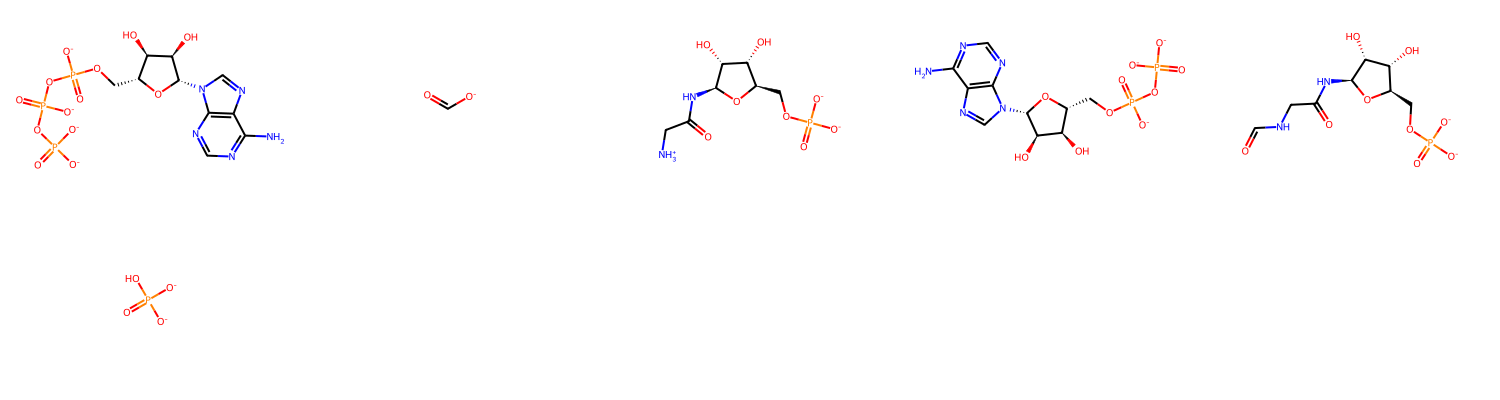

Test: 216


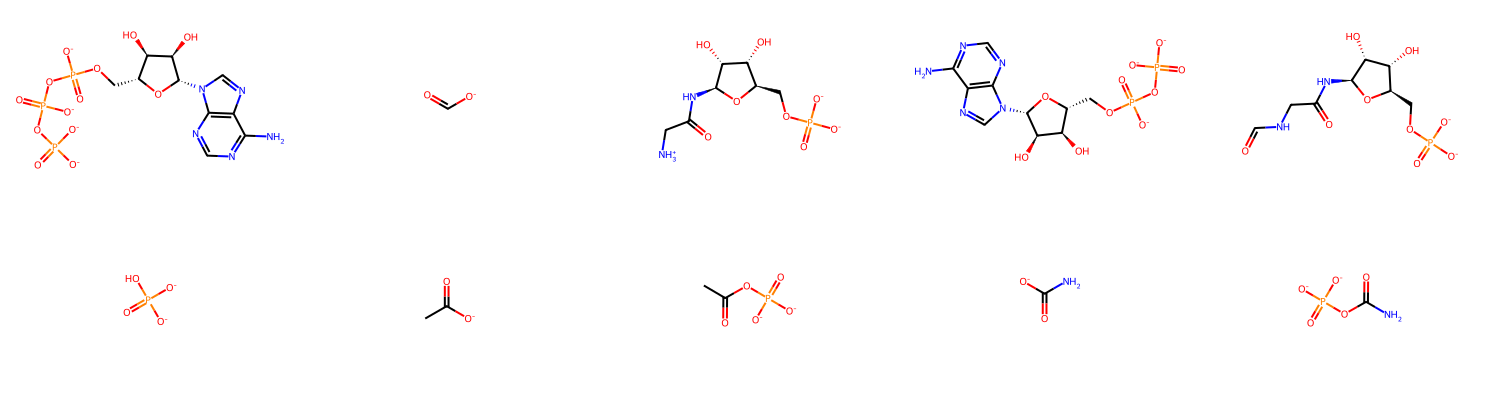

Train: 57496


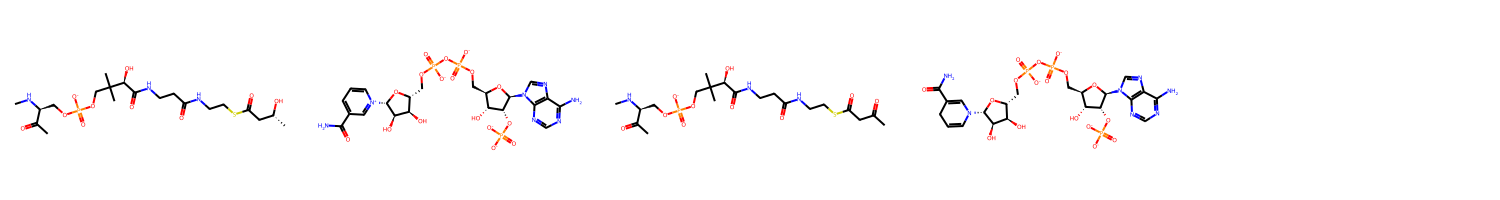

Test: 105


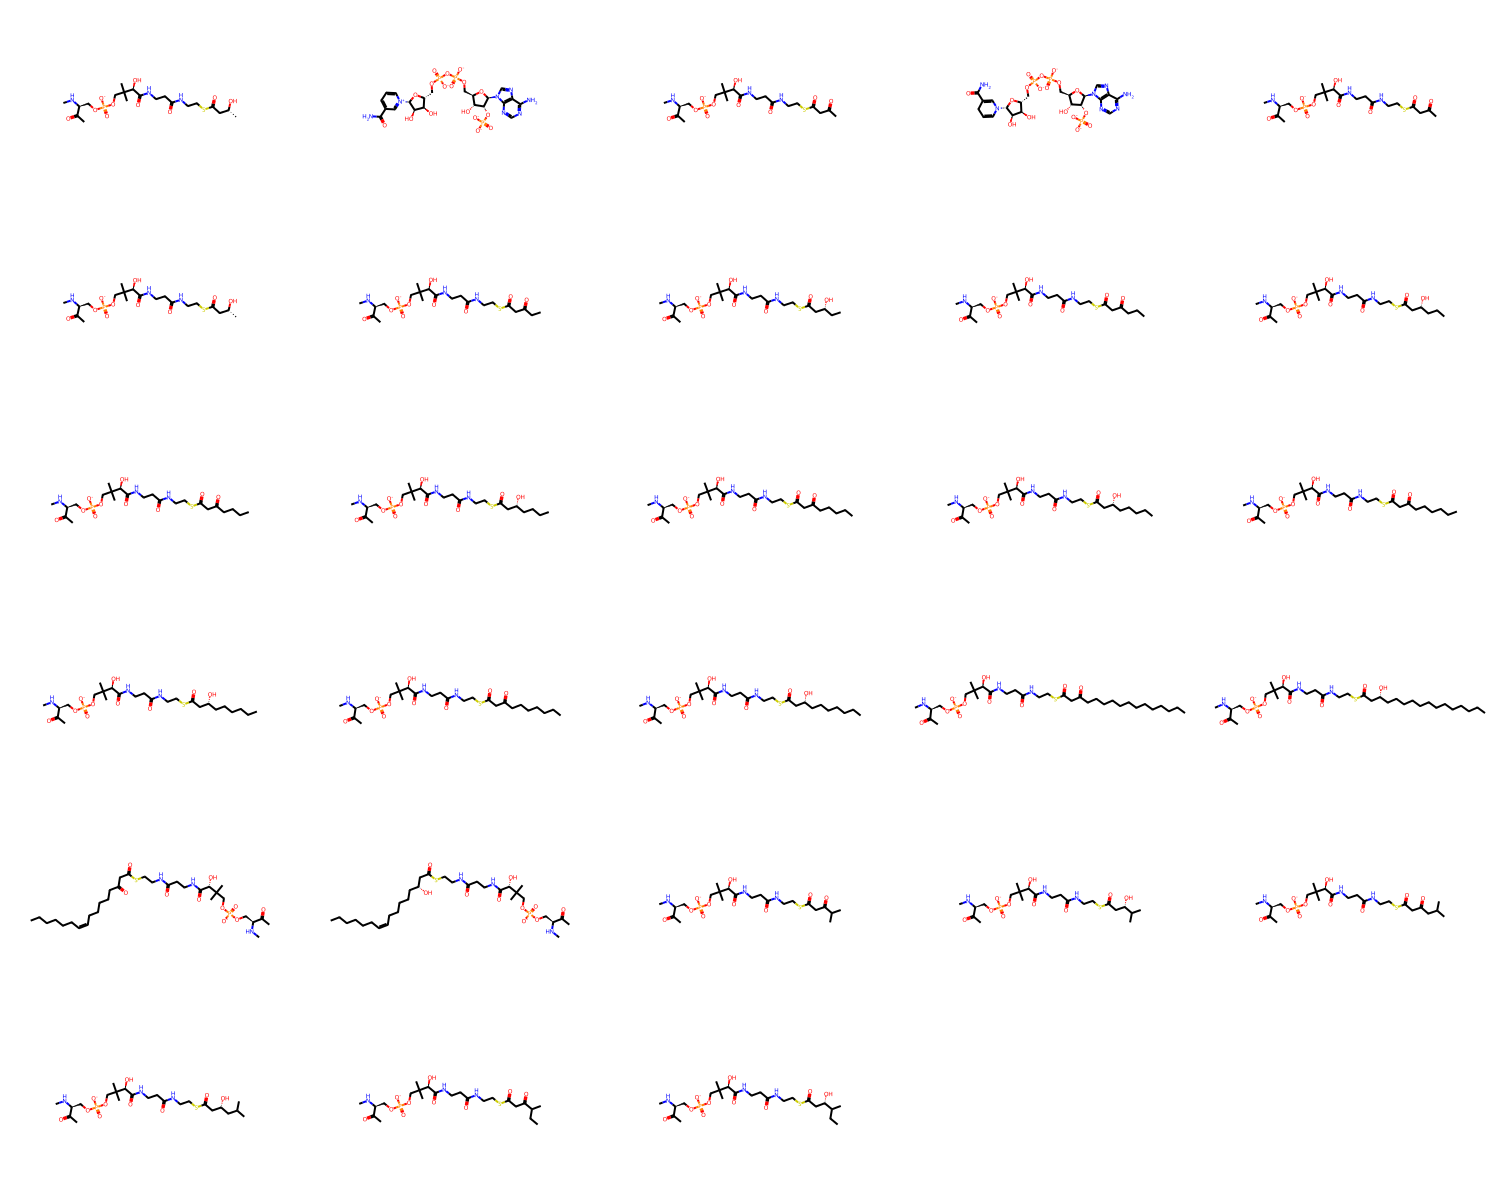

Train: 150373


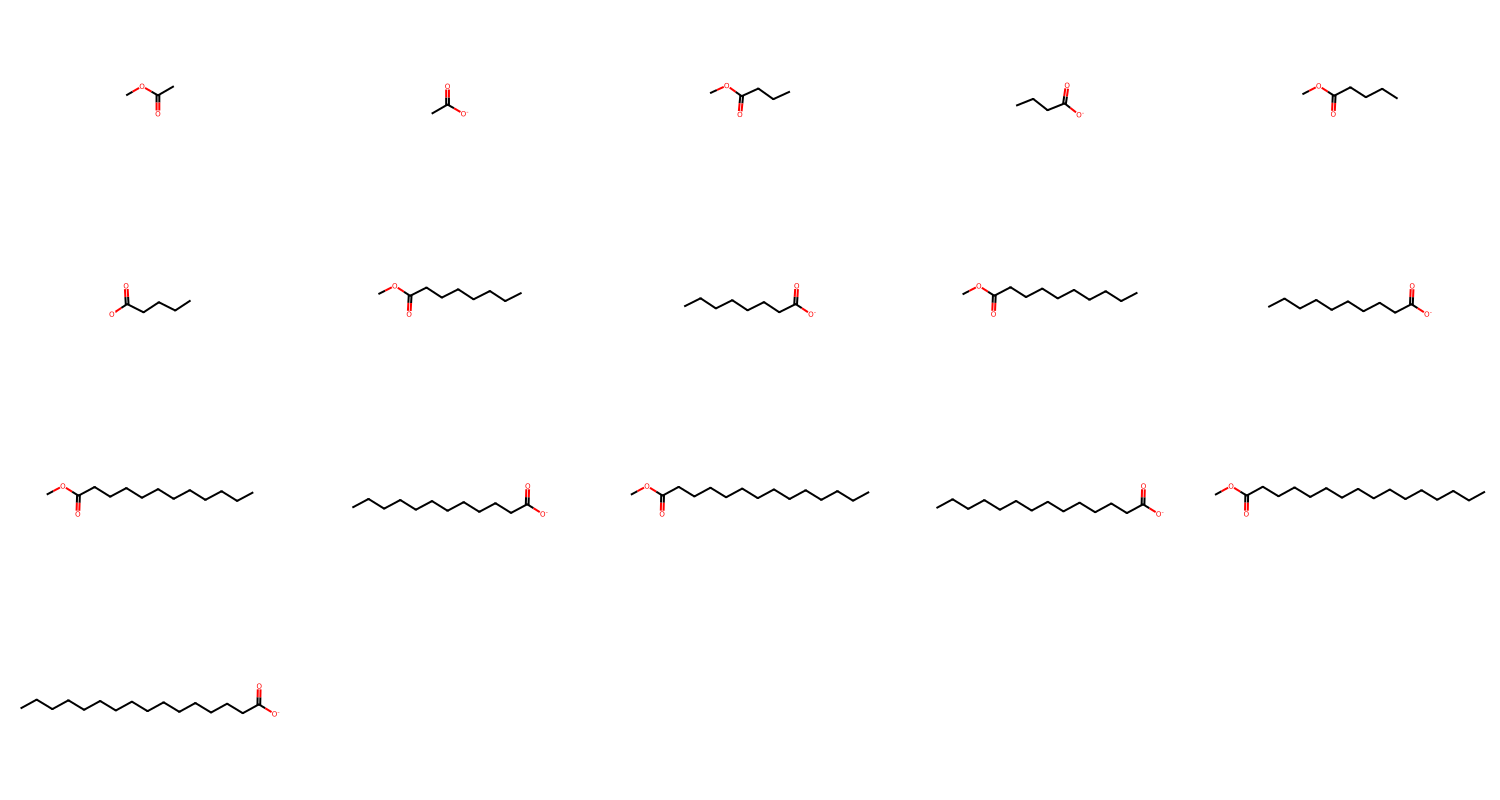

Test: 14068


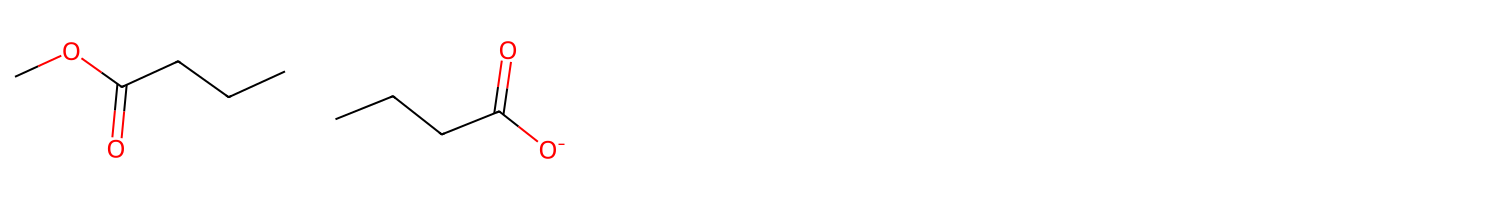

Train: 126813


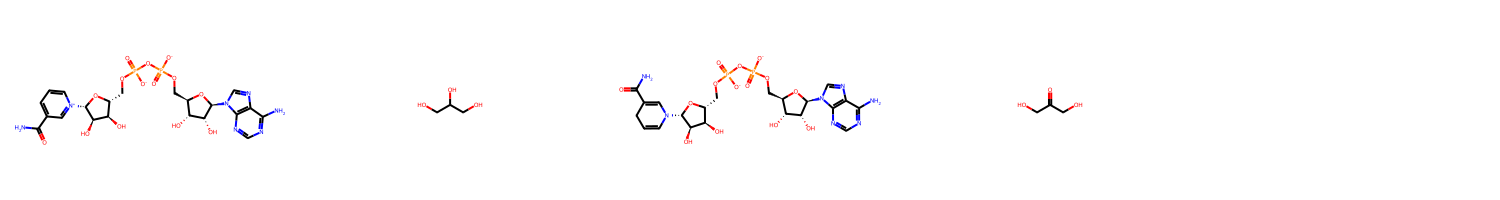

Test: 103


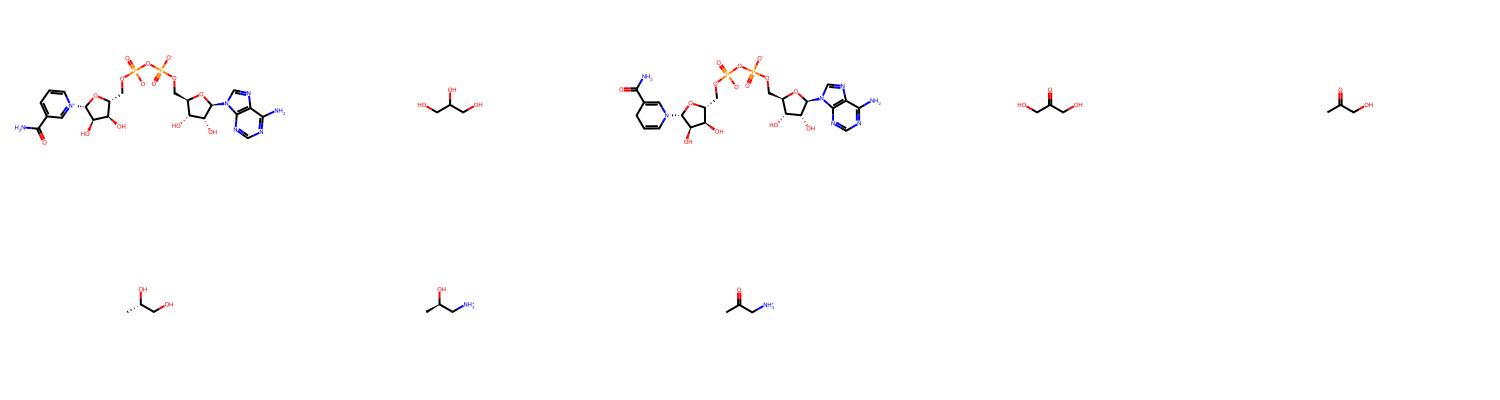

Train: 150923


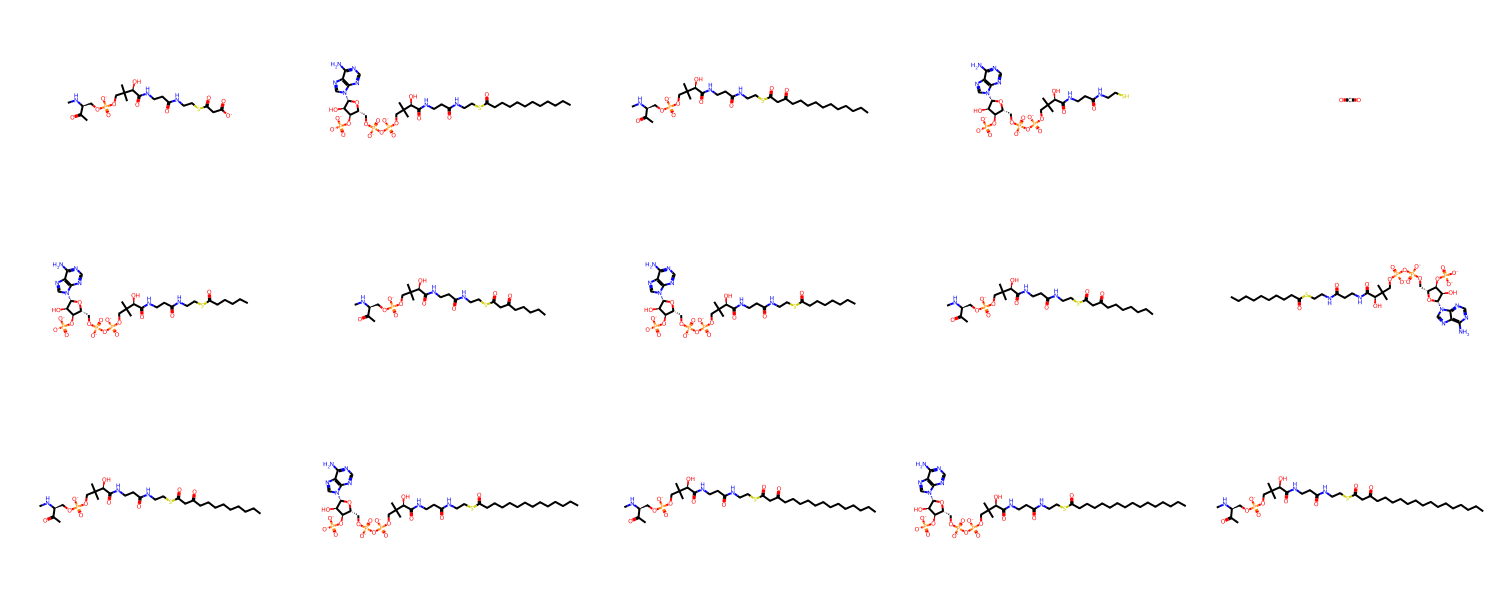

Test: 14415


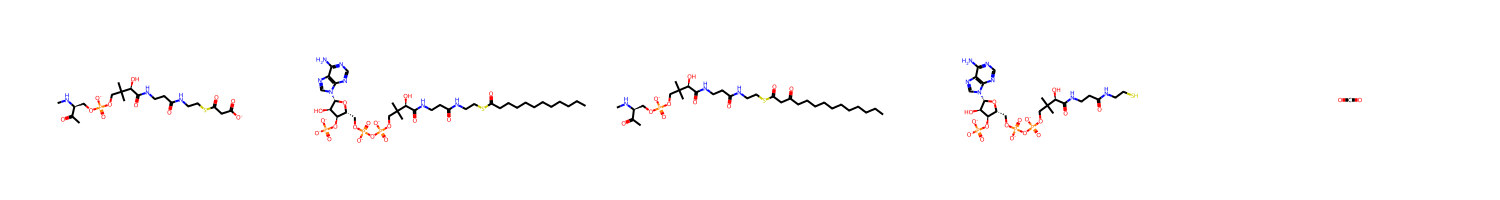

Train: 161147


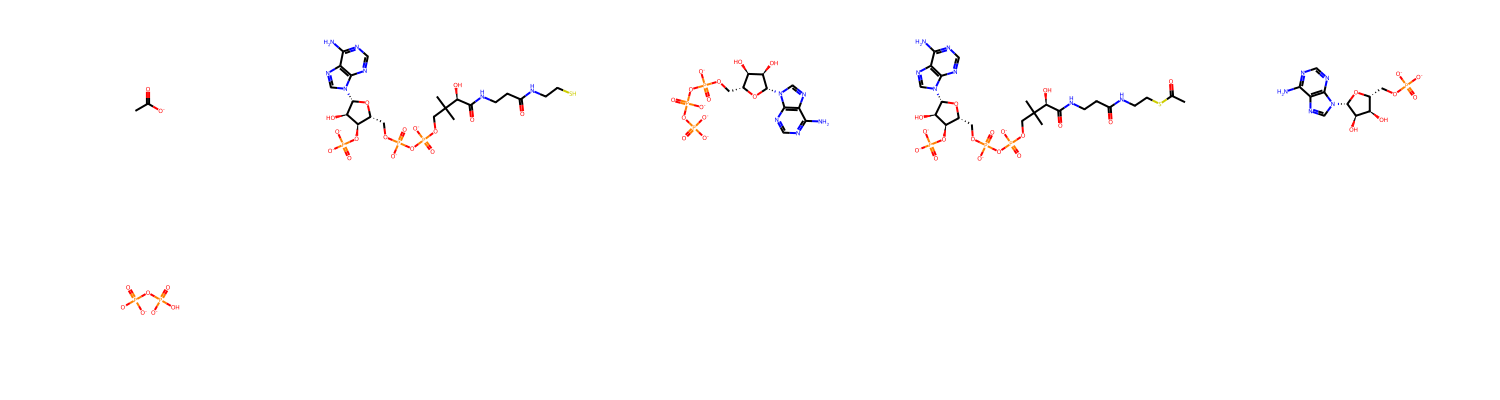

Test: 13857


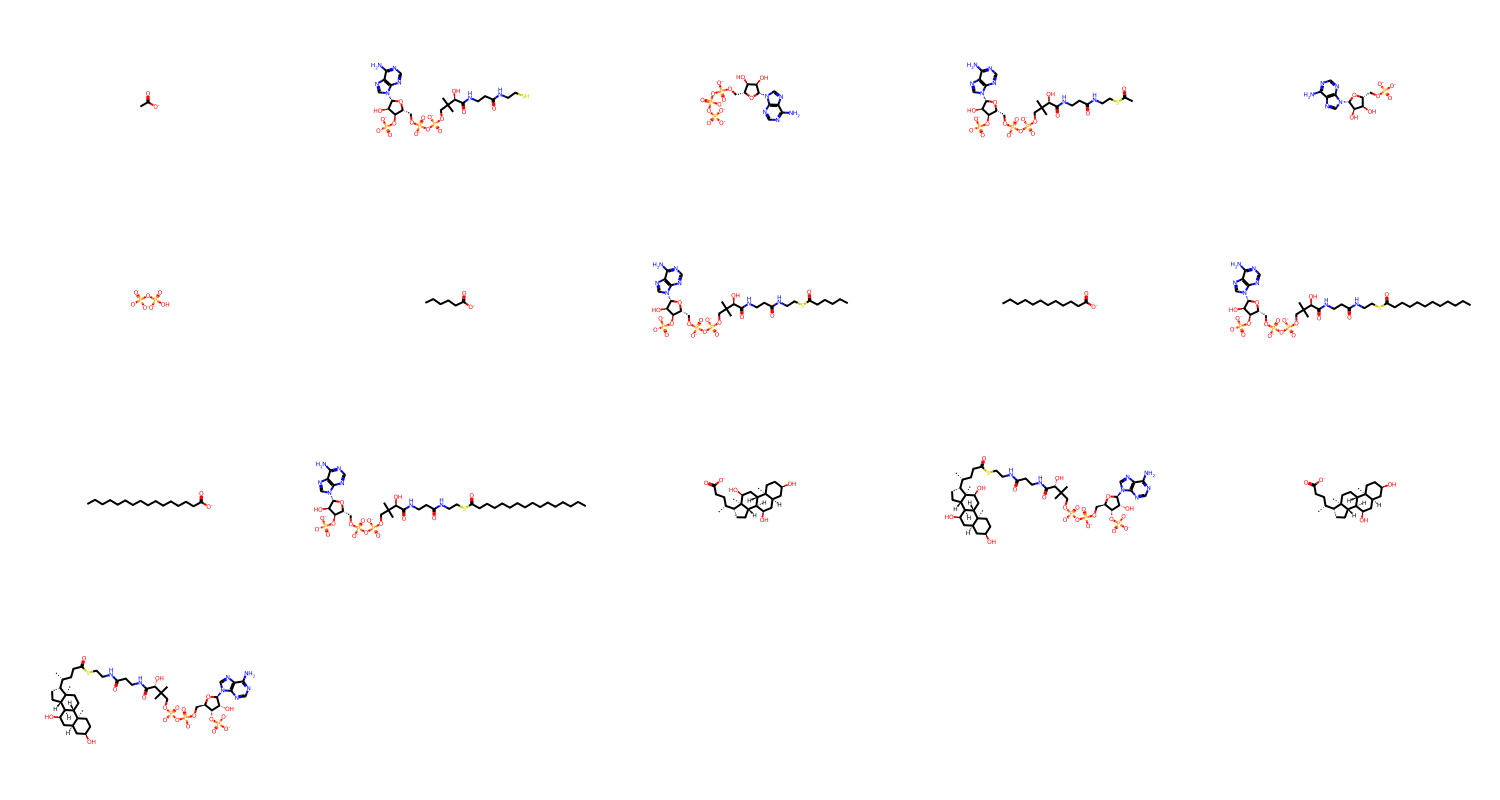

Train: 34265


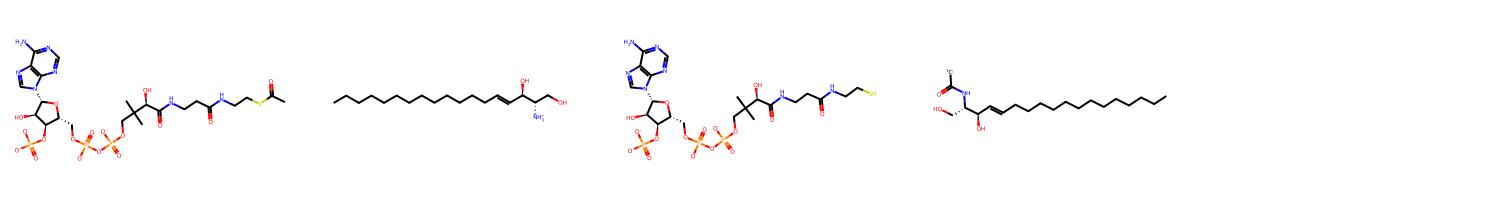

Test: 191


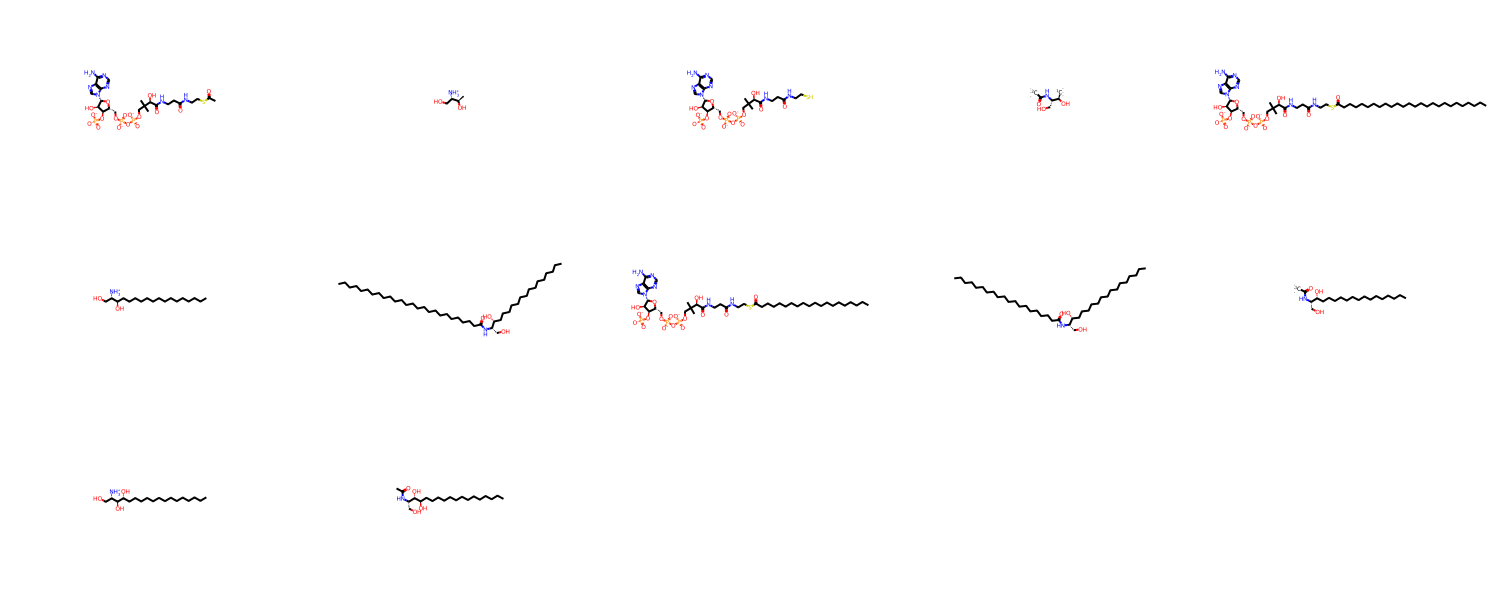

Train: 2121


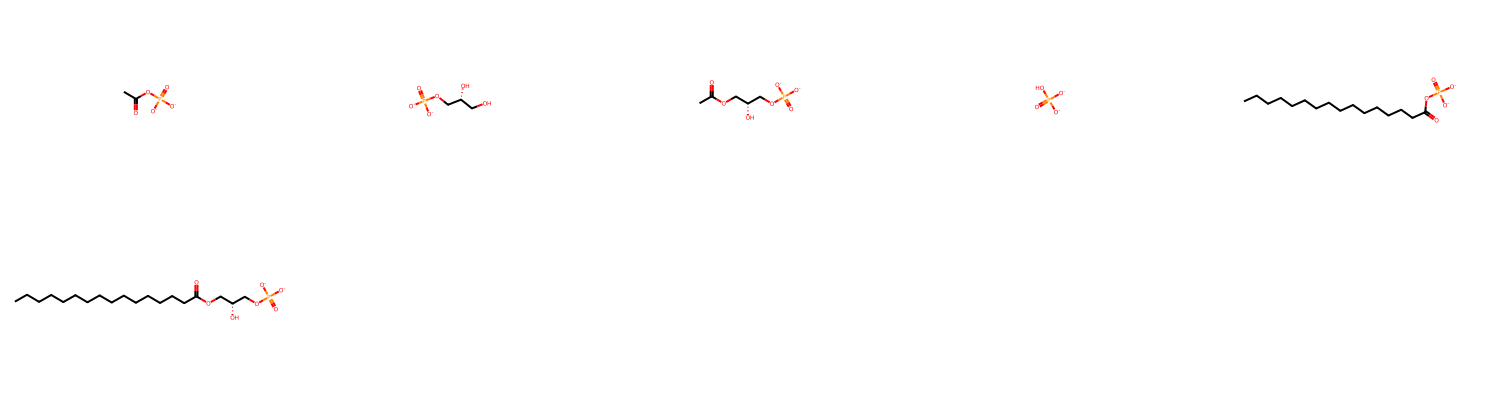

Test: 6405


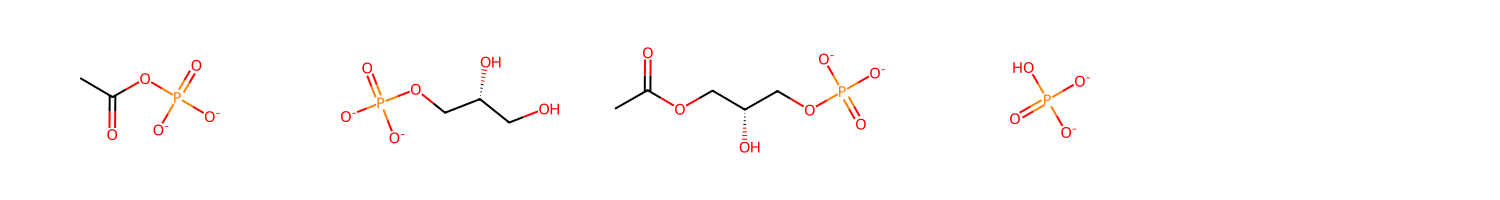

Train: 163210


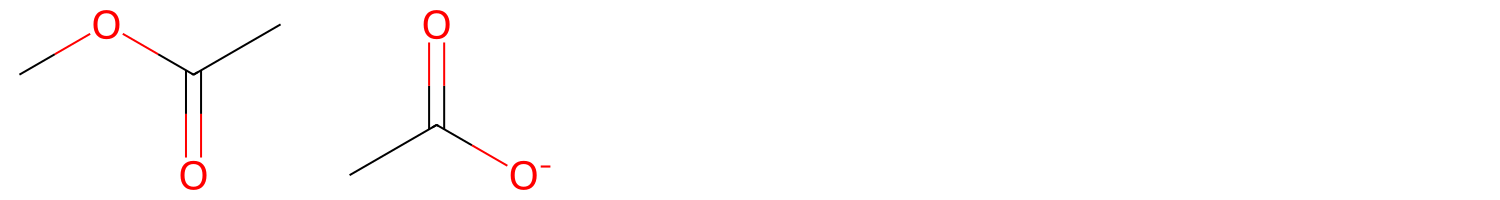

Test: 13869


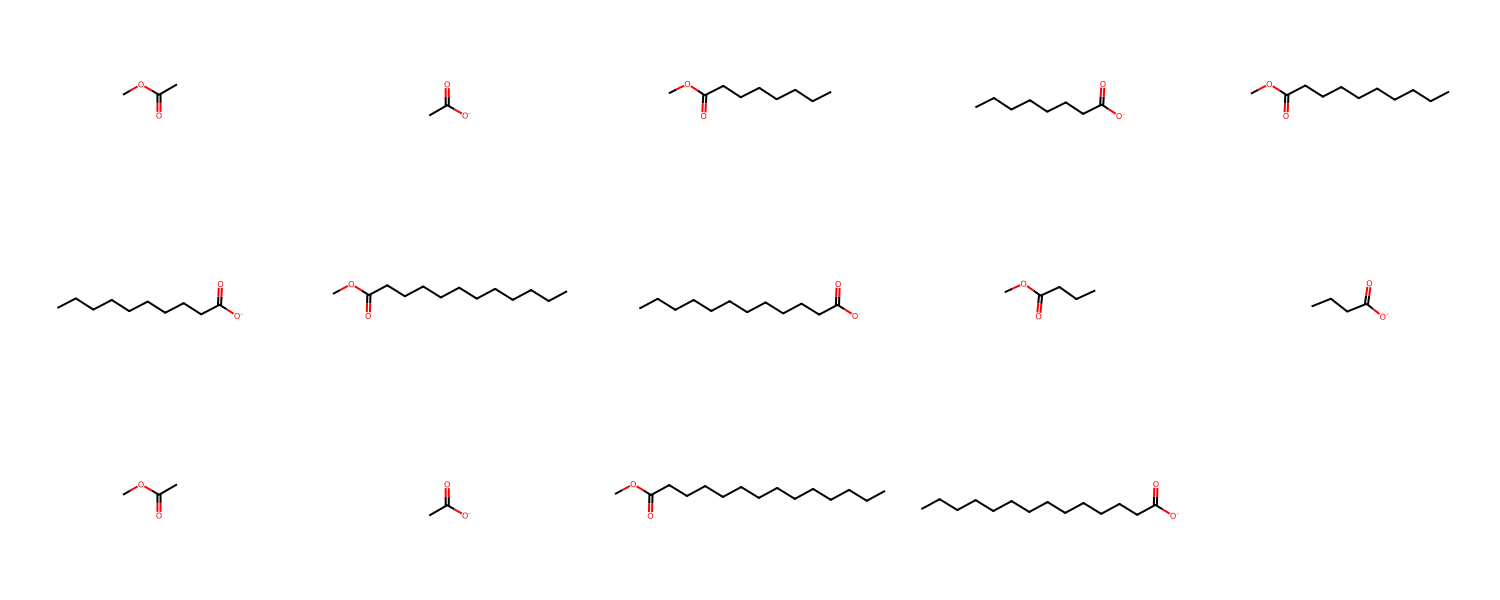

Train: 57464


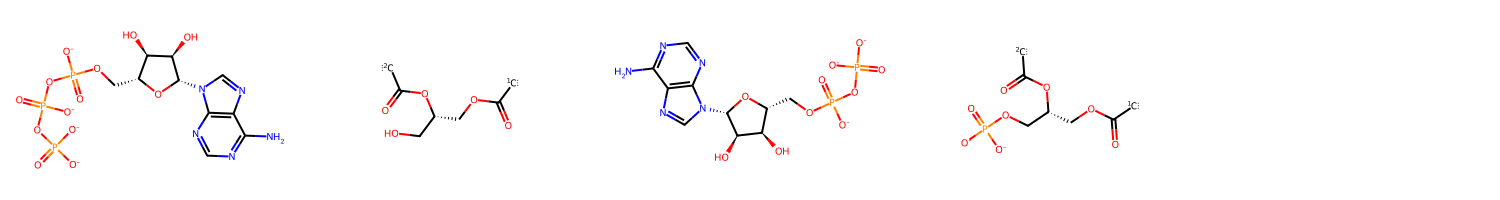

Test: 104


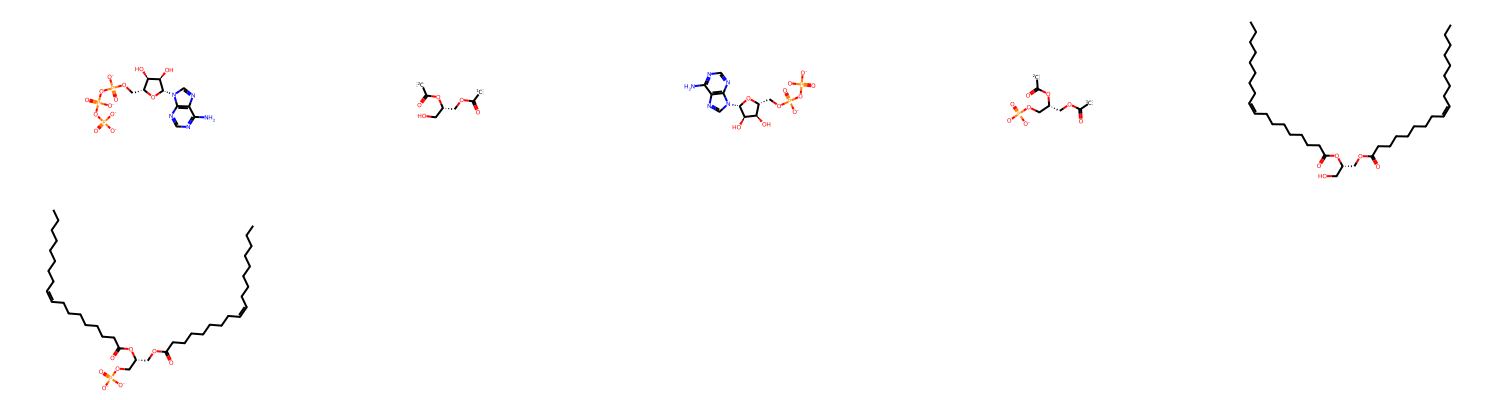

Train: 151506


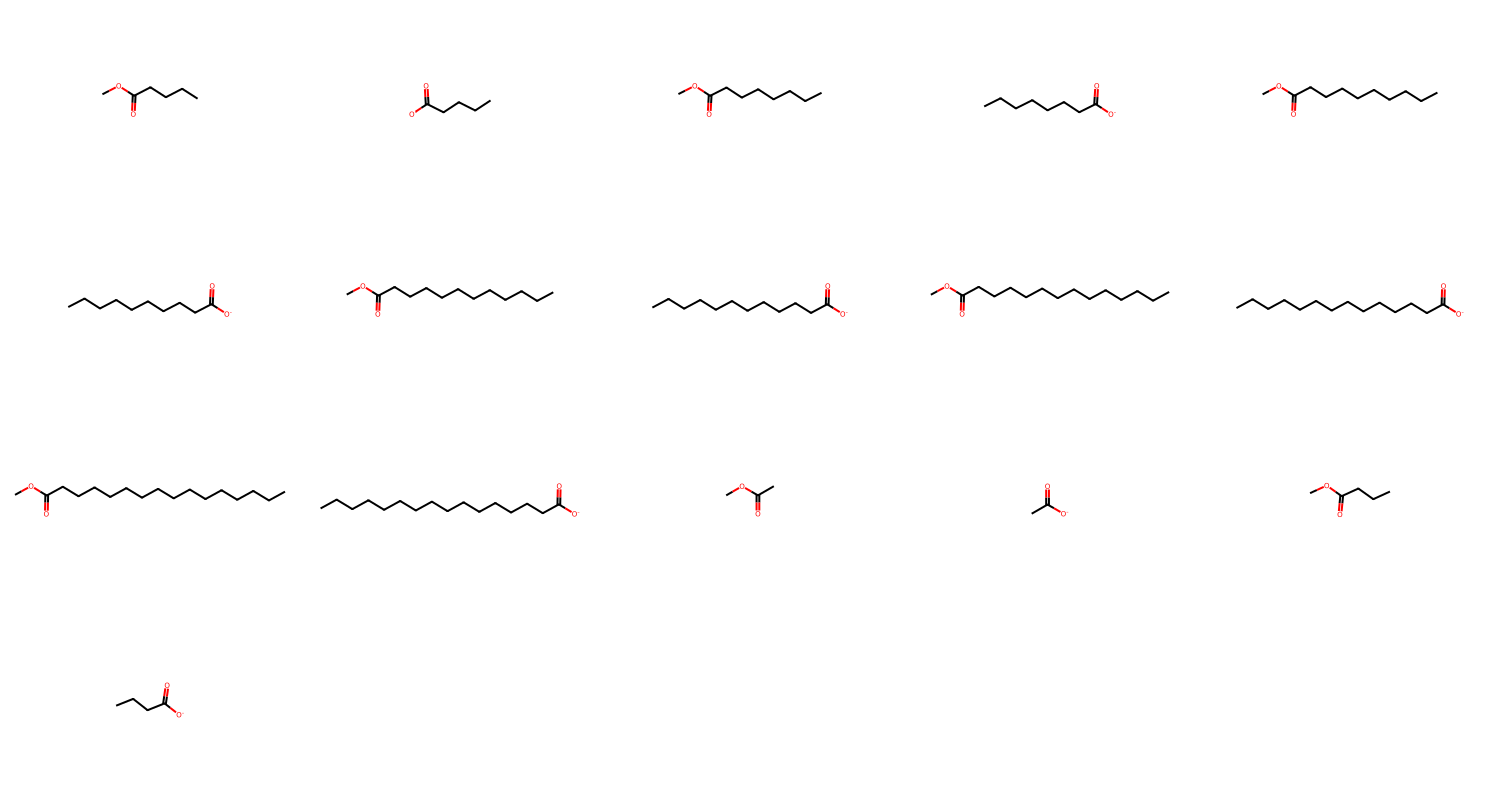

Test: 13889


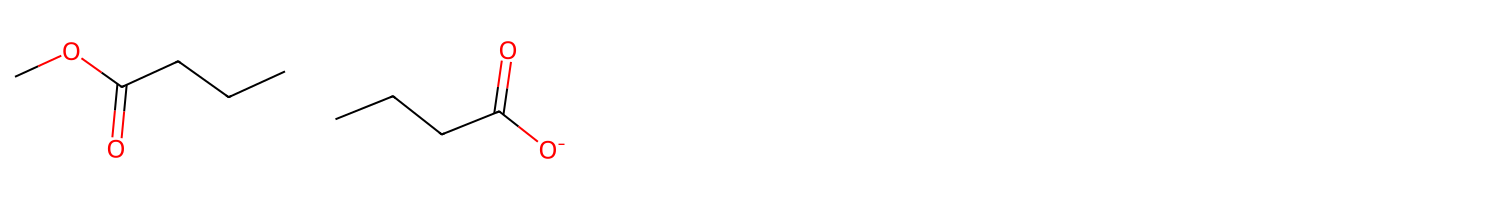

Train: 159941


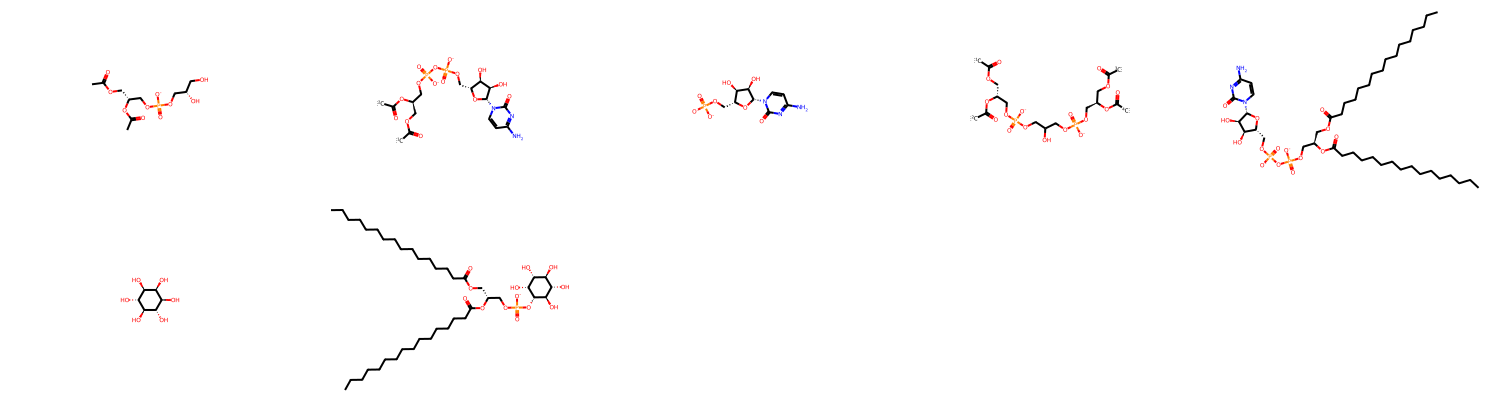

Test: 14671


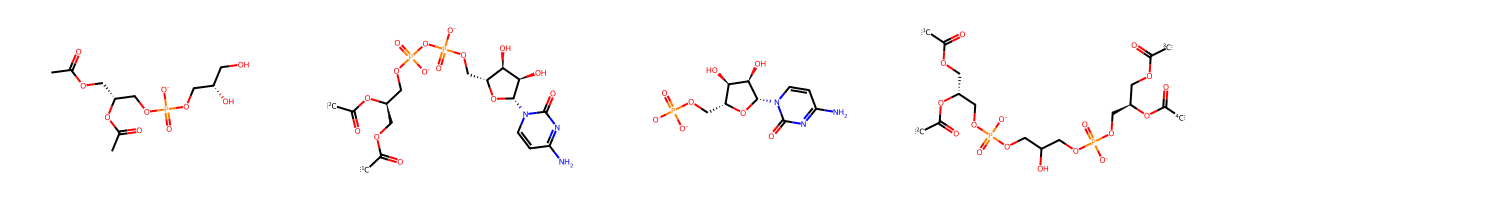

In [19]:
for train, test , seq in seq_leak:
    print(f"Train: {train}")
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in ptvms[train][0].split('.')], molsPerRow=5, subImgSize=(300,200)))
    print(f"Test: {test}")
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in ptms[test][0].split('.')], molsPerRow=5, subImgSize=(300,200)))

In [20]:
tr_te_pairs = list(product(train_smi, test_smi))
def is_either_subset(smi1: str, smi2: str) -> bool:
    st1 = set(smi1.split('.'))
    st2 = set(smi2.split('.'))
    inter = st1 & st2
    return len(inter) == min(len(st1), len(st2))

subset_pairs = []
for pair in tqdm(tr_te_pairs, total=len(tr_te_pairs)):
    if is_either_subset(pair[0], pair[1]):
        smi1 = pair[0]
        smi2 = pair[1]
        subset_pairs.append((smi1, smi2))


100%|██████████| 2706165/2706165 [00:06<00:00, 443231.81it/s] 


In [21]:
train_subset_leak, test_subset_leak = [set(elt) for elt in zip(*subset_pairs)]
print(len(train_subset_leak))
print(f"{len(test_subset_leak)} / {len(test_smi)} = {len(test_subset_leak)/len(test_smi):.2%}")

745
261 / 385 = 67.79%


In [22]:
i = 0


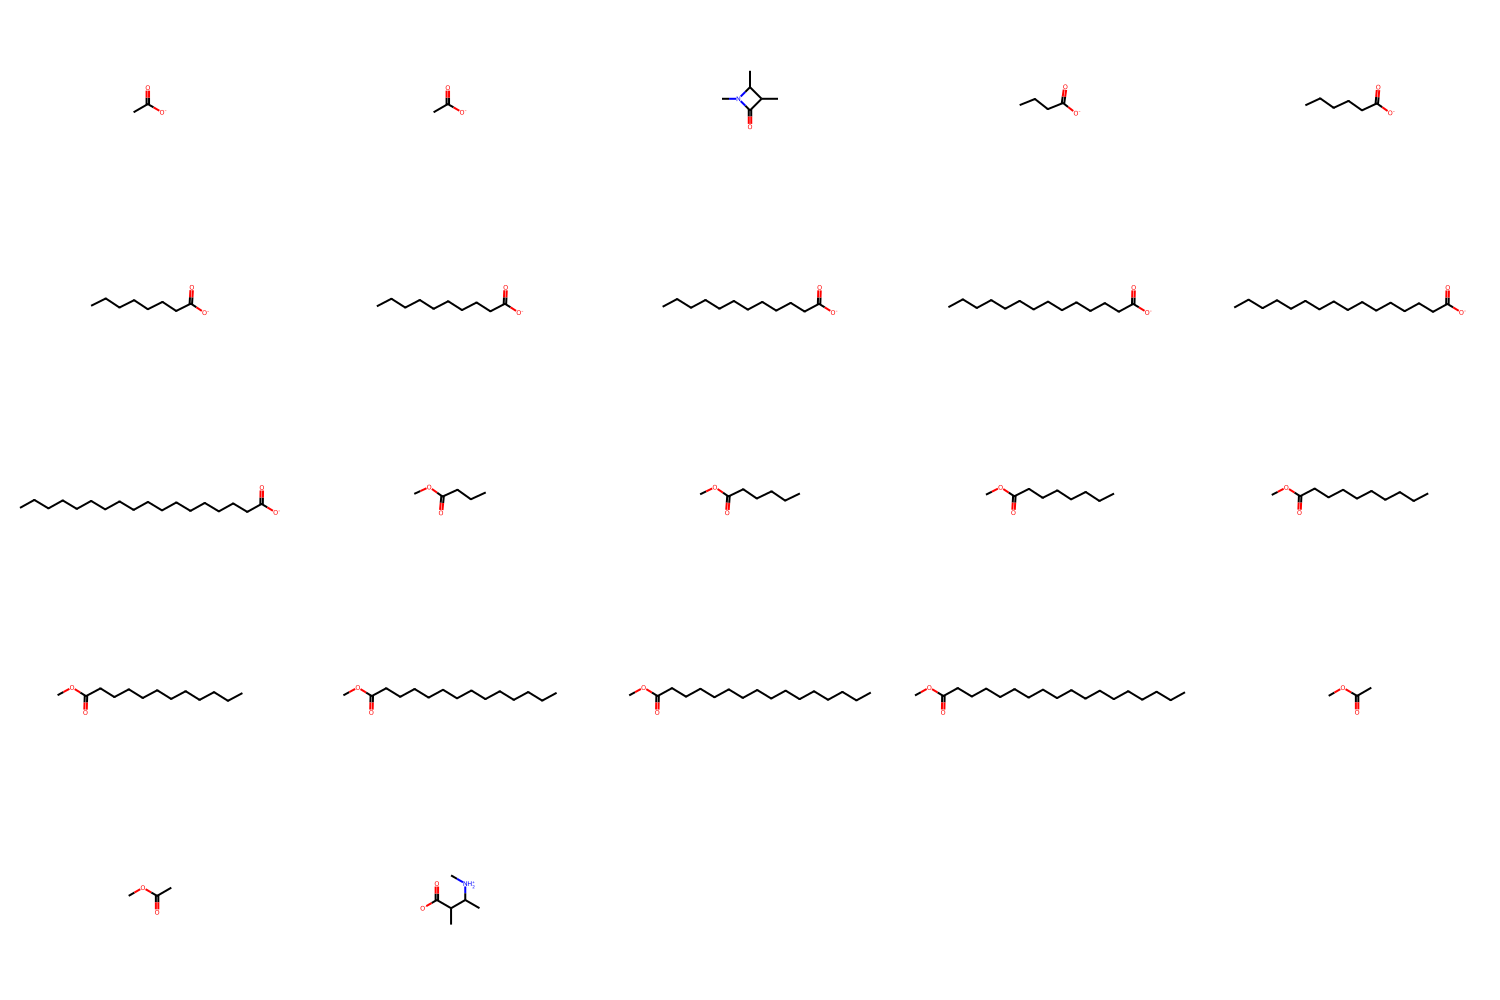

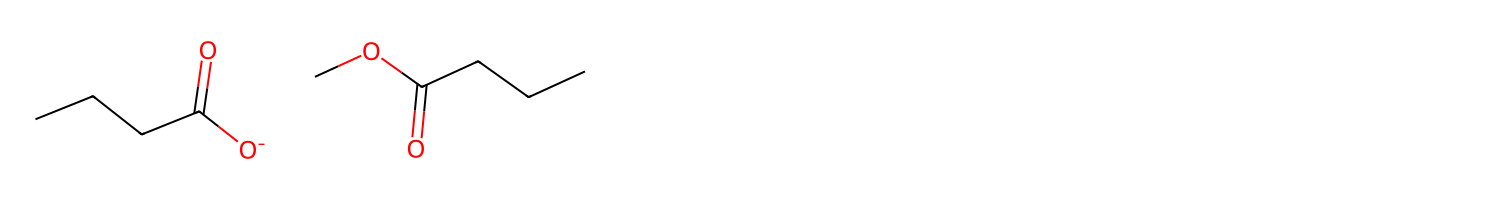

In [23]:

for elt in subset_pairs[i]:
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in elt.split('.')], molsPerRow=5, subImgSize=(300,200)))

i += 1

0: ['RHEA:13013', 'RHEA:42000', 'RHEA:56740']


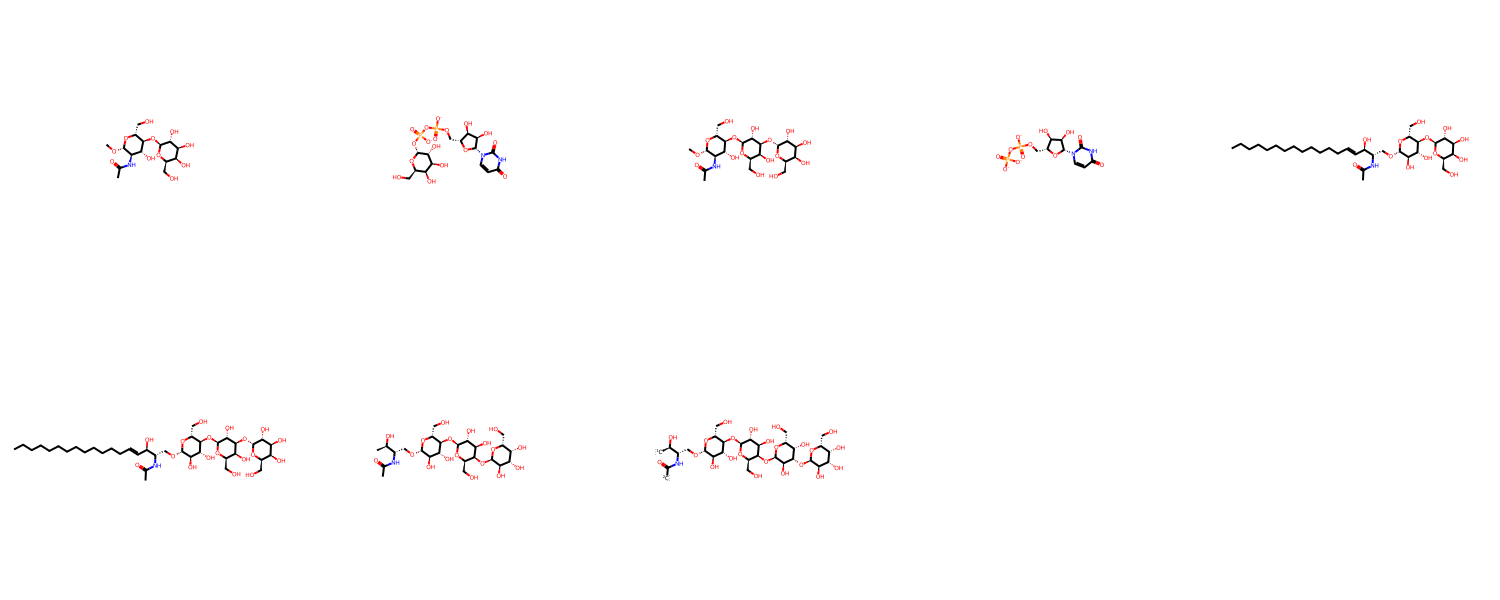

1: ['RHEA:32727', 'RHEA:35327', 'RHEA:36475', 'RHEA:35379', 'RHEA:36503', 'RHEA:36511', 'RHEA:35319', 'RHEA:35315', 'RHEA:36523']


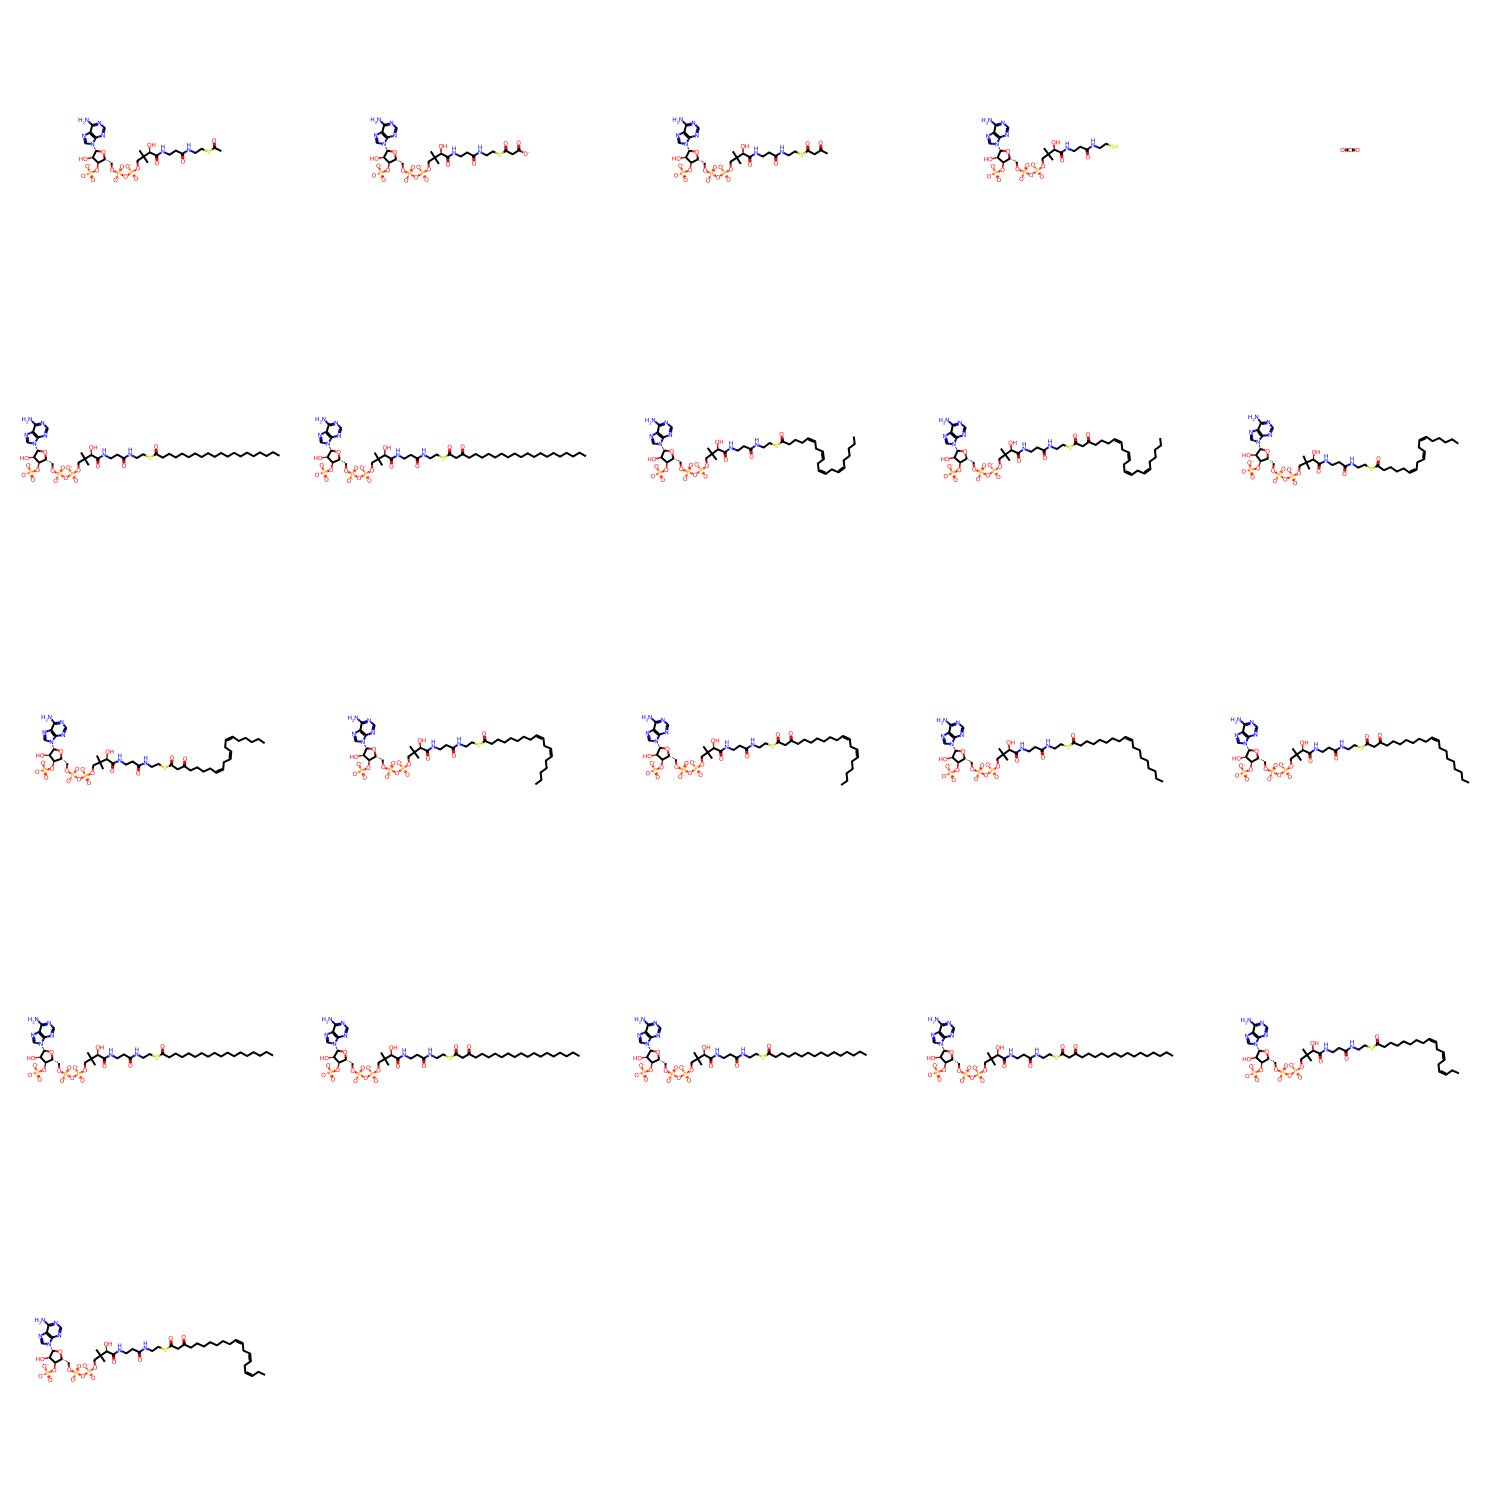

2: ['RHEA:30275', 'RHEA:20309']


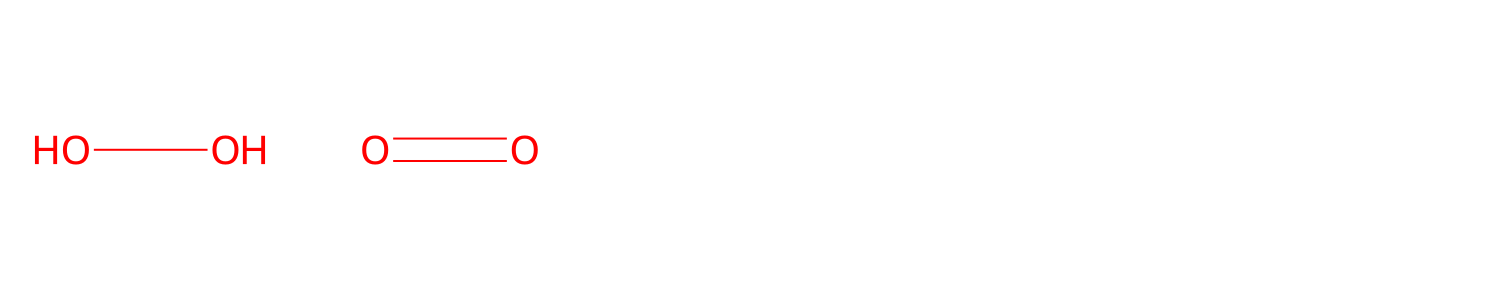

3: ['RHEA:32727', 'RHEA:35327', 'RHEA:36475', 'RHEA:35379', 'RHEA:36503', 'RHEA:36511', 'RHEA:35319', 'RHEA:35315', 'RHEA:36523']


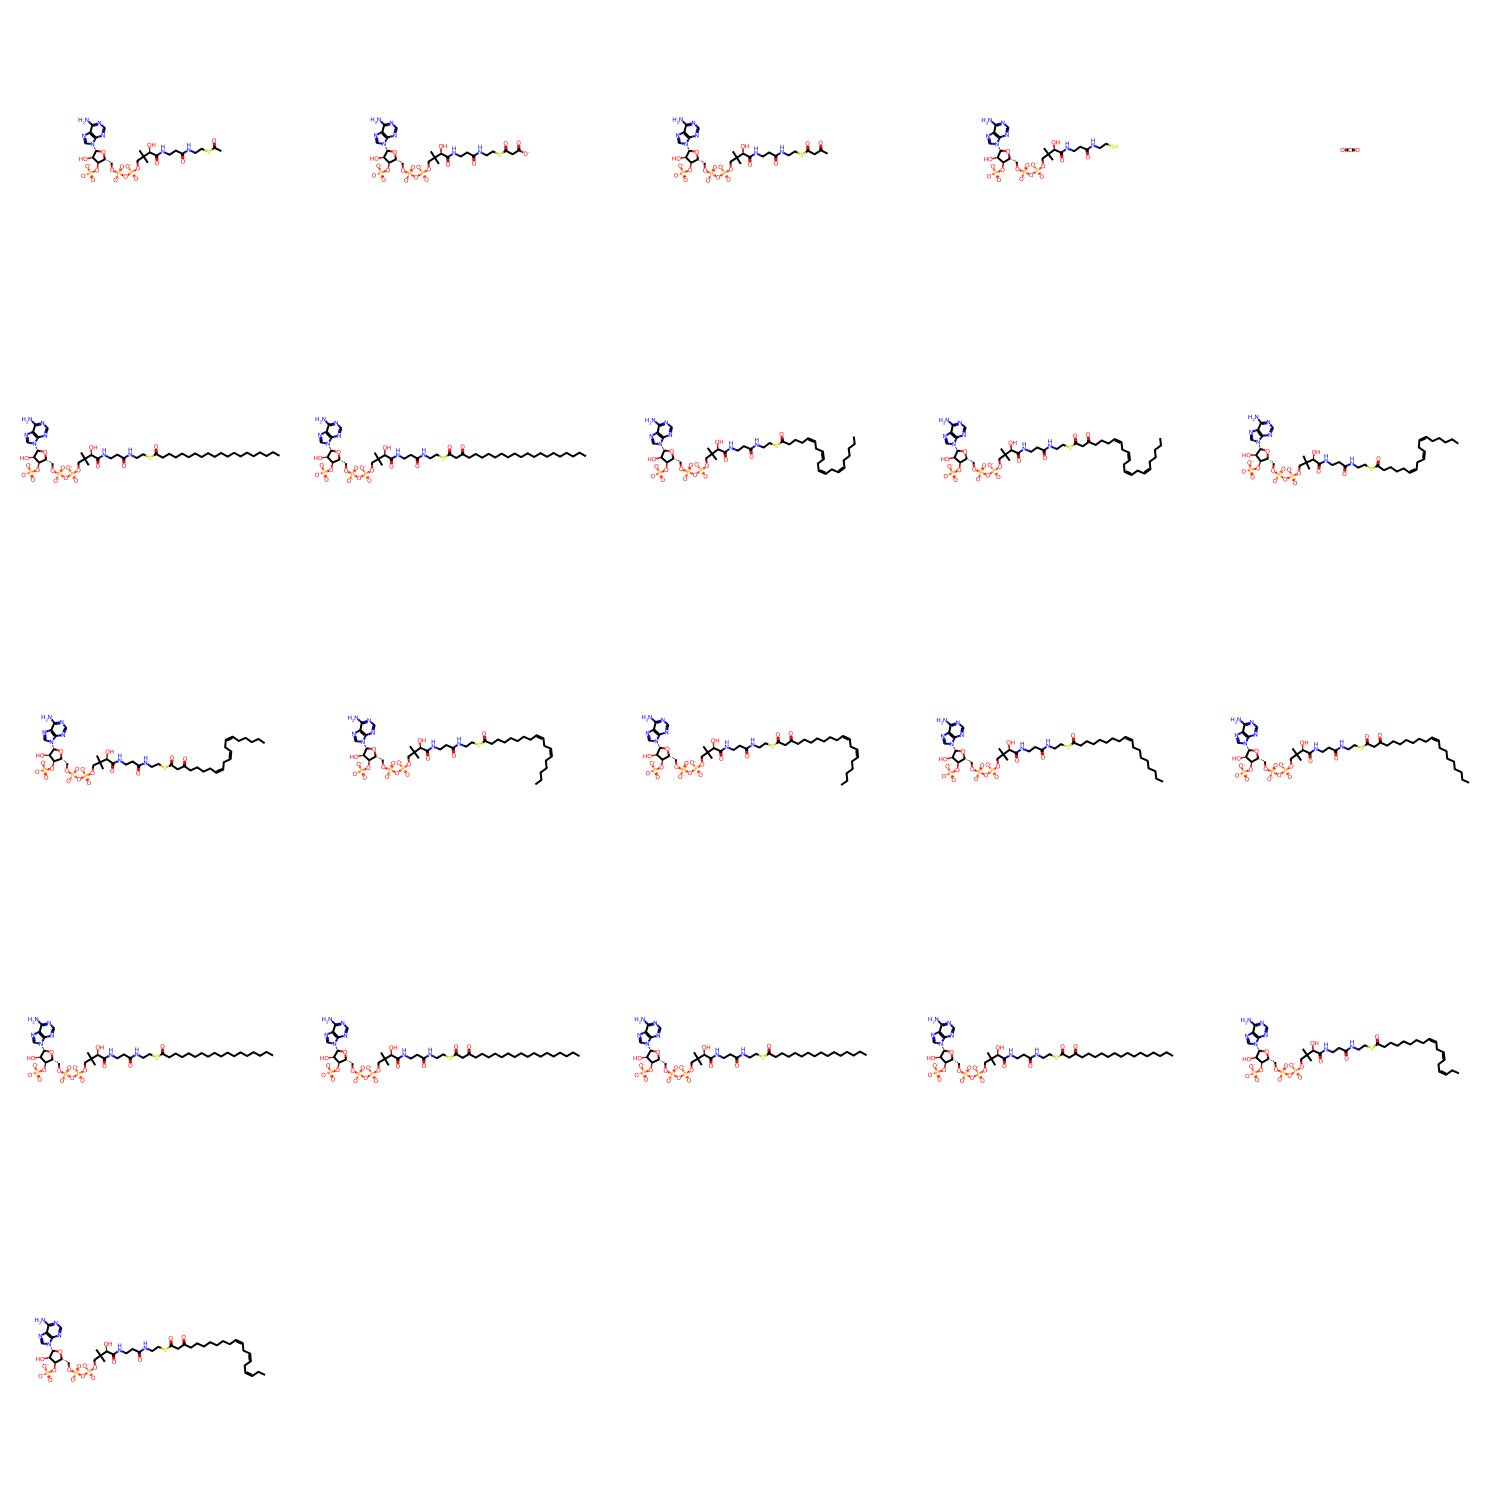

4: ['RHEA:50956', 'RHEA:50960', 'RHEA:60916']


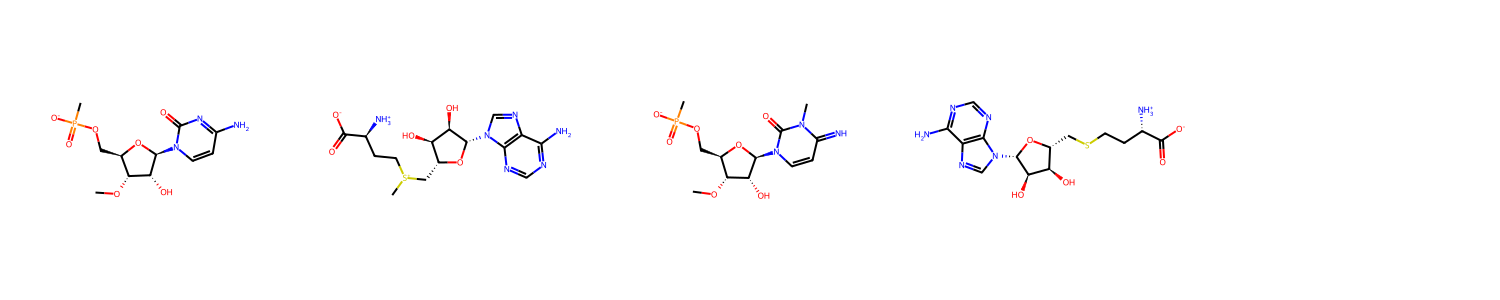

5: ['RHEA:10684', 'RHEA:20629', 'RHEA:47004']


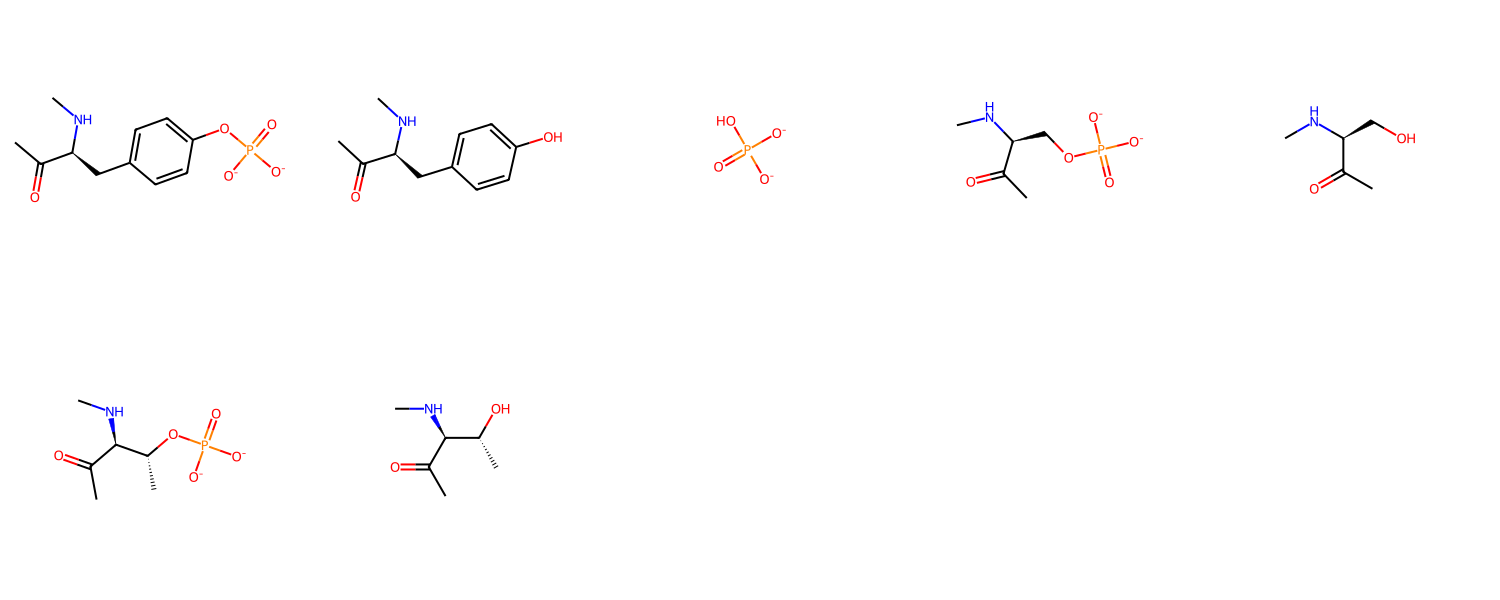

6: ['RHEA:30275', 'RHEA:20309']


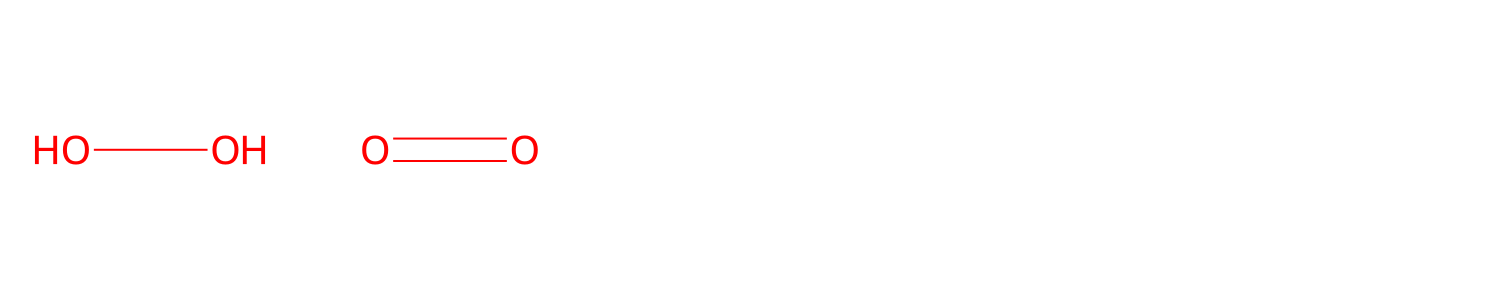

7: ['RHEA:30275', 'RHEA:20309']


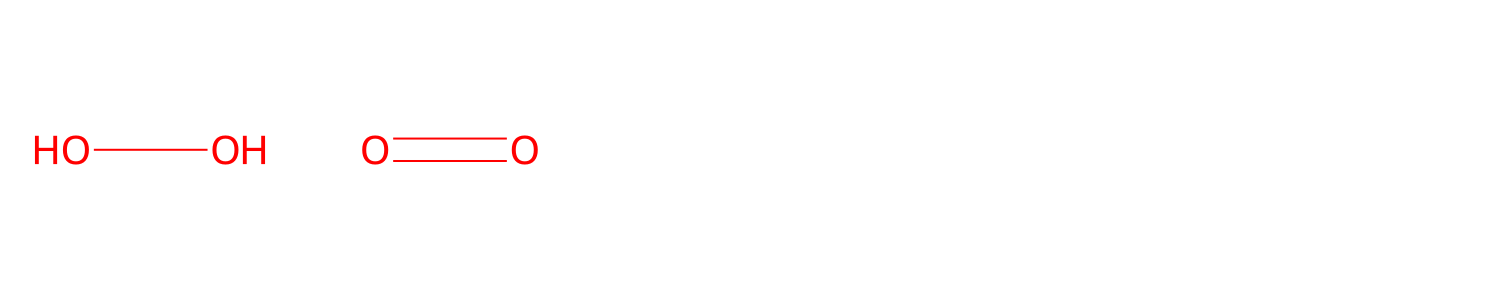

8: ['RHEA:48108']


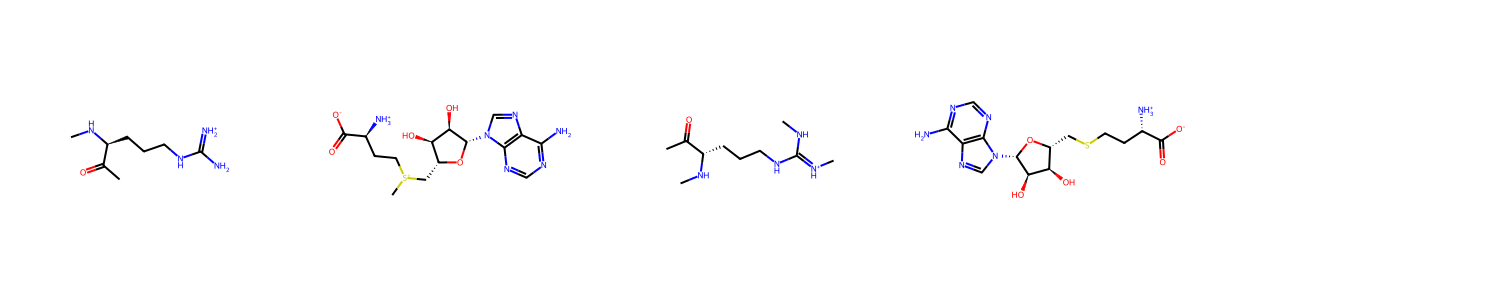

9: ['RHEA:16989']


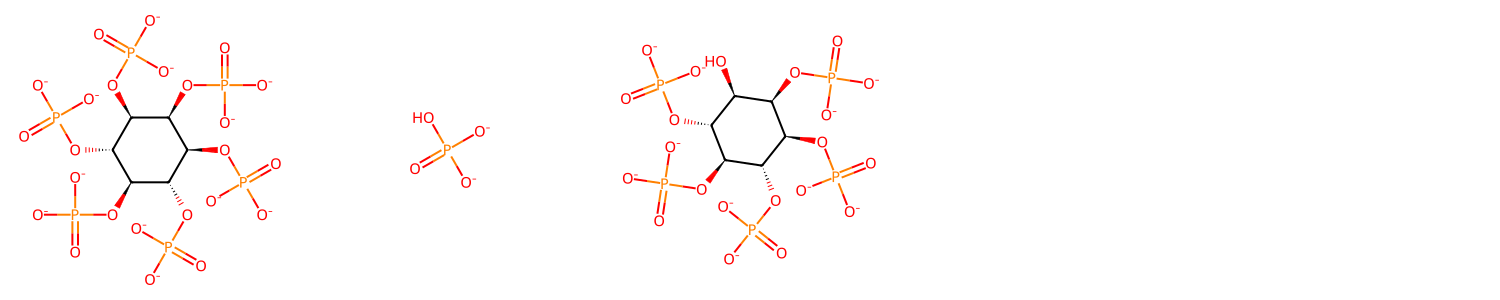

In [24]:
ptms_x_kr = {}
i = 1
ub = 10
for k, (smi, seq) in ptms.items():
    putative_rhea_ids = reactzyme.filter(pl.col("Sequence") == seq)['Rhea ID'].to_list()
    
    putative_rhea_ids = list(chain(*[rhea_id.split(";") for rhea_id in putative_rhea_ids]))
    print(f"{k}: {putative_rhea_ids}")
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(_smi) for _smi in smi.split(".")], molsPerRow=5, subImgSize=(300, 300)))

    i += 1
    if i > ub:
        break


Check reactzyme reaction splitting

In [25]:
def get_rhea_ids(split: dict[int: tuple[str, str]]) -> set[str]:
    rhea_ids = []
    for (smi, seq) in tqdm(split.values(), total=len(split)):
        this_ids = reactzyme.filter(pl.col("Sequence") == seq)['Rhea ID'].to_list()
        this_ids = list(chain(*[rhea_id.split(";") for rhea_id in this_ids]))
        rhea_ids.extend(this_ids)
    return set(rhea_ids)

In [26]:
# test_rhea_ids = get_rhea_ids(ptms)
# train_rhea_ids = get_rhea_ids(ptvms)

# with open(Path(cfg.data) / "reactzyme" / "test_rhea_ids.txt", 'w') as f:
#     for rhea_id in test_rhea_ids:
#         f.write(f"{rhea_id}\n")

# with open(Path(cfg.data) / "reactzyme" / "train_rhea_ids.txt", 'w') as f:
#     for rhea_id in train_rhea_ids:
#         f.write(f"{rhea_id}\n")

In [27]:
with open(Path(cfg.data) / "reactzyme" / "test_rhea_ids.txt", 'r') as f:
    test_rhea_ids = set(line.strip() for line in f)

with open(Path(cfg.data) / "reactzyme" / "train_rhea_ids.txt", 'r') as f:
    train_rhea_ids = set(line.strip() for line in f)

In [28]:
rhea_directions = pl.read_csv(
    Path(cfg.data) / "rhea-directions.tsv",
    separator="\t",
)
rhea_directions.head()

RHEA_ID_MASTER,RHEA_ID_LR,RHEA_ID_RL,RHEA_ID_BI
i64,i64,i64,i64
10000,10001,10002,10003
10004,10005,10006,10007
10008,10009,10010,10011
10012,10013,10014,10015
10016,10017,10018,10019


In [29]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
metric = 'rcmcs'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(
    Path(cfg.data) / dataset / (toc + '.csv')
)

feature_idx = {v: k for k, v in idx_feature.items()}

with open(Path(cfg.data) / dataset / 'v3_folded_pt_ns.json', 'r') as f:
    v3_rxns = json.load(f)

rhea2idx = {}
for idx, v in v3_rxns.items():
    for rhea_id in v['rhea_ids']:
        rhea2idx[rhea_id] = int(idx)

for row in rhea_directions.iter_rows():
    idxs = [rhea2idx[int(rhea_id)] for rhea_id in row if int(rhea_id) in rhea2idx]
    if len(idxs) == 0:
        continue
    else:
        assert len(set(idxs)) == 1
        idx = idxs[0]

        for rhea_id in row:
            if rhea_id not in rhea2idx:
                rhea2idx[int(rhea_id)] = idx


reactzyme_train_idxs = set()
reactzyme_test_idxs = set()
for rhea_id in train_rhea_ids:
    rhea_id = int(rhea_id.removeprefix("RHEA:"))
    if rhea_id in rhea2idx:
        reactzyme_train_idxs.add(rhea2idx[rhea_id])

for rhea_id in test_rhea_ids:
    rhea_id = int(rhea_id.removeprefix("RHEA:"))
    if rhea_id in rhea2idx:
        reactzyme_test_idxs.add(rhea2idx[rhea_id])

reactzyme_train_idxs = np.array(list(reactzyme_train_idxs))
reactzyme_test_idxs = np.array(list(reactzyme_test_idxs))
print(len(reactzyme_train_idxs), len(reactzyme_test_idxs))

Constructing v3_folded_pt_ns sparse adjacency matrix
6120 649


In [30]:


S = np.load(
    Path(cfg.results) / 'similarity_matrices' / f"{dataset}_{toc}_{metric}.npy"
)

S = S.astype(np.float16)

In [31]:
S.shape

(6460, 6460)

In [32]:
print(len(train_rhea_ids), len(test_rhea_ids))
print(len(train_rhea_ids & test_rhea_ids))

10490 979
627
